# Classification

---


## Metrics

**_Accuracy_**: the ratio of correct predictions. $$ \text{Acurracy} = \frac{TP + TN}{\text{Total}} $$

**_Precision_**: is the accuracy of the positive predctions. $$ \text{Precision} = \frac{TP}{\text{TP + FP}} $$

**_Recall_**: is the _true positive rate_, that is, the ratio of positive instances that are correctly detected by the classifier. Also is called of sensitivity. $$ \text{Recall} = \frac{TP}{TP + FN} $$

**_F1-score_**: is the harmonic mean of precision and recall, the higher the better. $$ \text{F1-score} = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} $$

**_Macro F1-score_**: is the arithimetic mean of the F1-score calculated per class. **Should be used when the dataset is imbalanced**. $$ \text{Macro F1-score} = \frac{\sum_i^C \text{F1-score}_i}{C} $$

**_Micro F1-score_**: is the total regular formula for F1-score, but using the total number of True Positives and Negatives, False Positives and Negatives, instead of individually for each class. $$ \text{Micro F1-score} = \frac{TP}{TP + \frac{1}{2} \times (FP + FN)} $$

**_Receiver Operating Characteristic (ROC) Curve_**: is tool **used with binary classifiers**. It plots the _true positive rate (recall)_ against the _false positive rate (FPR)_

- The _FPR_ is the ratio of negative instances tha are incorrectly classified as positive. Can also be defined as $1 - TNR$.
- The _true negative rate (TNR)_ is the ration of negative instances that are correctly classified as negative. Is also called _specificity_.

**_Confusion Matrix_**: the rows represent actual classes and the columns represent predicted classes. Analyzing the confusion matrix often gives us insights into ways to improve our classifiers.

> Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. **This is called the precision/recall trade-off**.

> **If someone says, “Let’s reach 99% precision,” you should ask, “At what recall?”**

> As a rule of thumb, you should prefer the precision/recall curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. 



## Functions

- `cross_val_score()`
- `cross_val_predict()`
- `precision_recall_curve()`
- `roc_curve()`
- `roc_auc_score()`
- `confusion_matrix()`


## Other concepts

- A system that outputs multiple binary tags for each data instance is called a _**multilabel classification**_ system.

- Multiclass classification refers to those classifications tasks that have more than two classes, but they keep being mutually exclusive. 

- The algorithms that only support binary classification can be adapted to run multiclass classification using the One-versus-Rest or One-versus-One strategies.

- Multioutput classification refers to those task where each data instance can have multiple binary tags and each tag (label) can have multiple values (multiclass).

---

# Exercises

Results:

- `GaussianNB`: f1_macro = 0.52
- `BernoulliNB`: f1_macro = 0.82
- `KNeighborsClassifier`: f1_macro = 0.93

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import shift


from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

## Data

In [2]:
mnist = fetch_openml("mnist_784", version=1, parser="auto", as_frame=True)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
type(mnist.data)

pandas.core.frame.DataFrame

In [5]:
mnist.target.value_counts()

1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: class, dtype: int64

In [35]:
train_images, train_labels, test_images, test_labels = train_test_split(
    mnist.data, mnist.target, test_size=0.4, random_state=42
)

train_images, test_images, train_labels, test_labels = (
    train_images.to_numpy(),
    train_labels.to_numpy(),
    test_images.to_numpy(),
    test_labels.to_numpy(),
)

In [7]:
type(train_images)

numpy.ndarray

In [8]:
train_images.shape

(42000, 784)

In [9]:
train_labels.shape

(42000,)

In [10]:
def plot_digit(image, ax):
    image = image.reshape(28, 28)

    ax.imshow(image, cmap="binary")
    ax.axis("off")

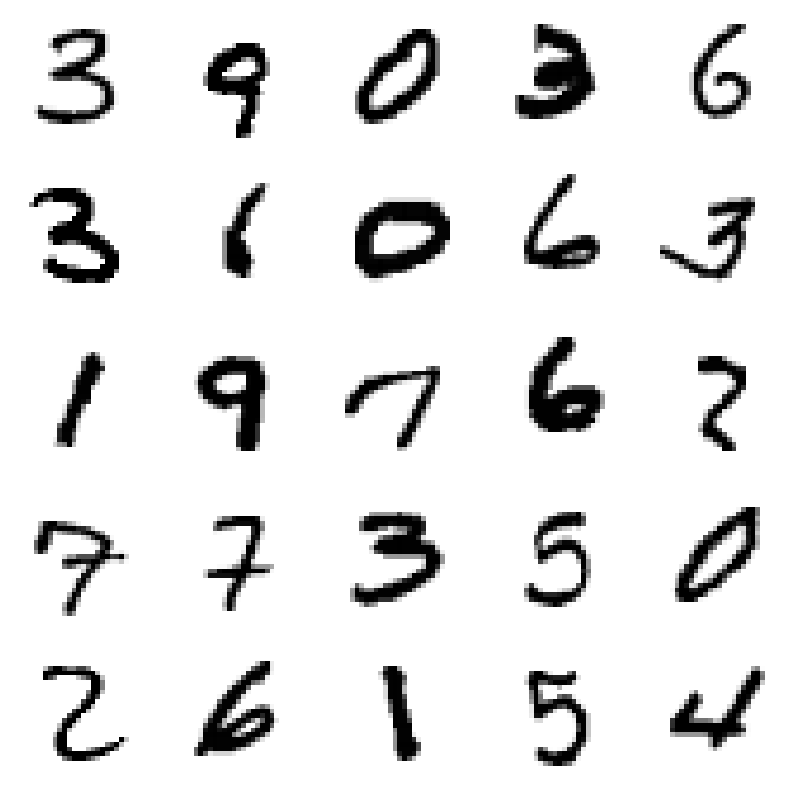

In [11]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

samples = train_images[np.random.choice(train_images.shape[0], 25)]

for s, ax in zip(samples, axes.flatten()):
    plot_digit(s, ax)

plt.show()

## Data Augmentation

In [12]:
def data_augmentation(raw_image, dx, dy):
    image = raw_image.reshape(28, 28)
    image = shift(image, shift=(dx, dy))
    return image.flatten()

In [13]:
shifted_images = []
for dx, dy in ((5, 0), (-5, 0), (0, 5), (0, -5)):
    shifted_images.extend([data_augmentation(image, dx, dy) for image in train_images])

# TODO: precisa aleatorizar a distribuição dos exemplos depois de aumentar o dataset

train_images = np.vstack((train_images, shifted_images))
train_labels = np.hstack([train_labels] * 5)

In [14]:
train_images.shape

(210000, 784)

In [15]:
train_labels.shape

(210000,)

In [33]:
np.unique(train_labels)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

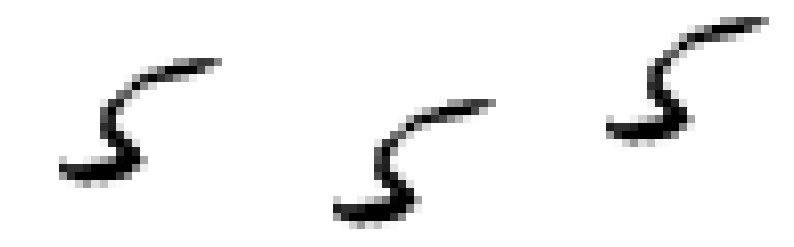

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

samples = [train_images[0], train_images[42000], train_images[84000]]

for s, ax in zip(samples, axes.flatten()):
    plot_digit(s, ax)

plt.show()

## Classifiers

In [36]:
classifier = Pipeline([("scaler", StandardScaler()), ("classifier", KNeighborsClassifier(weights="uniform", n_neighbors=5))])
classifier.fit(X=train_images, y=train_labels)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier())])

In [37]:
train_predicted_labels = cross_val_predict(classifier, train_images, train_labels, cv=3)

In [38]:
print(classification_report(train_labels, train_predicted_labels))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4125
           1       0.94      0.99      0.97      4718
           2       0.94      0.92      0.93      4184
           3       0.92      0.94      0.93      4312
           4       0.94      0.92      0.93      4176
           5       0.91      0.91      0.91      3769
           6       0.95      0.97      0.96      4110
           7       0.93      0.93      0.93      4308
           8       0.96      0.87      0.91      4160
           9       0.90      0.92      0.91      4138

    accuracy                           0.94     42000
   macro avg       0.93      0.93      0.93     42000
weighted avg       0.94      0.94      0.93     42000



## Confusion Matrix

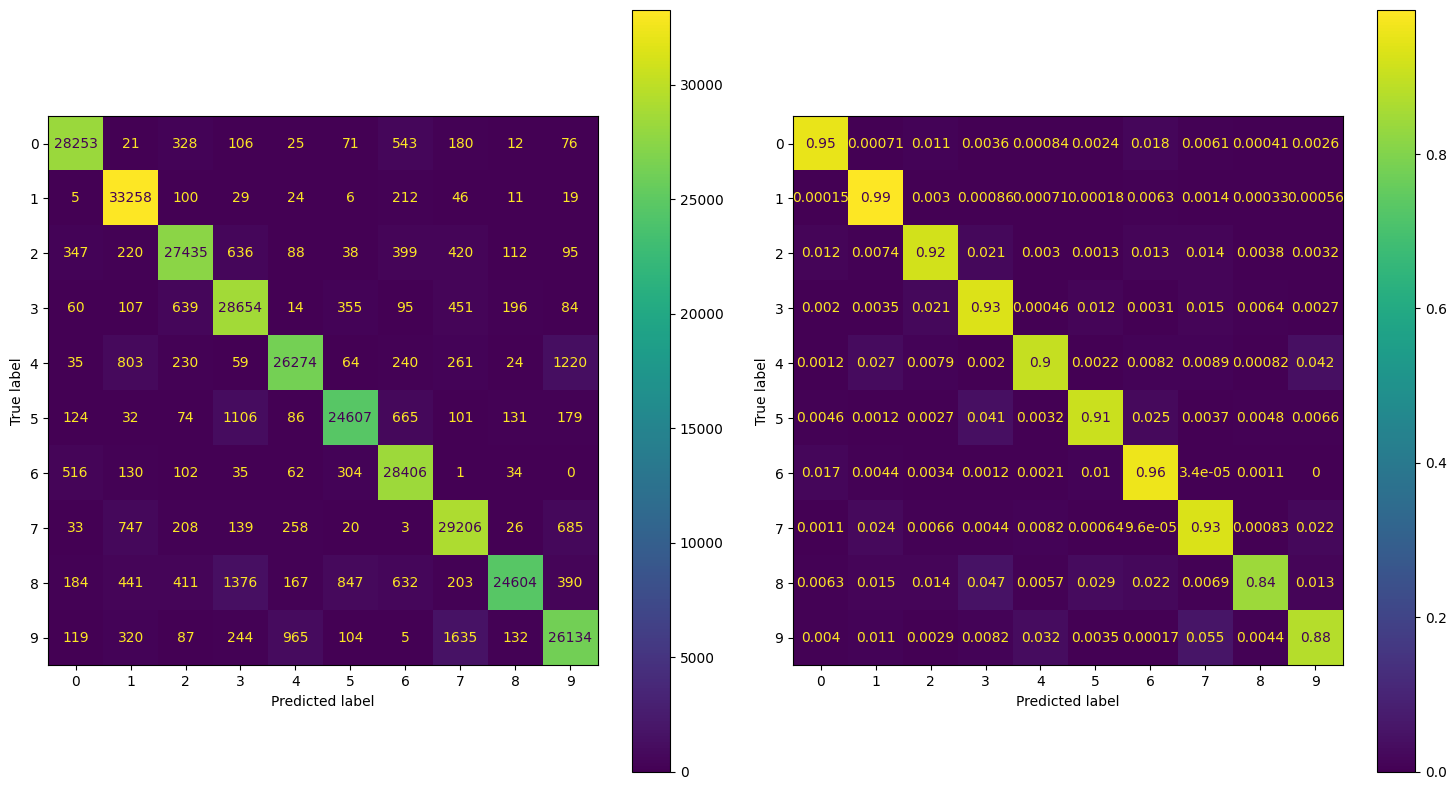

In [22]:
np.set_printoptions(precision=2)
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

ConfusionMatrixDisplay.from_predictions(
    train_labels, train_predicted_labels, display_labels=classifier.classes_, ax=axes[0]
)

ConfusionMatrixDisplay.from_predictions(
    train_labels,
    train_predicted_labels,
    display_labels=classifier.classes_,
    ax=axes[1],
    normalize="true",
)

plt.tight_layout()
plt.show()

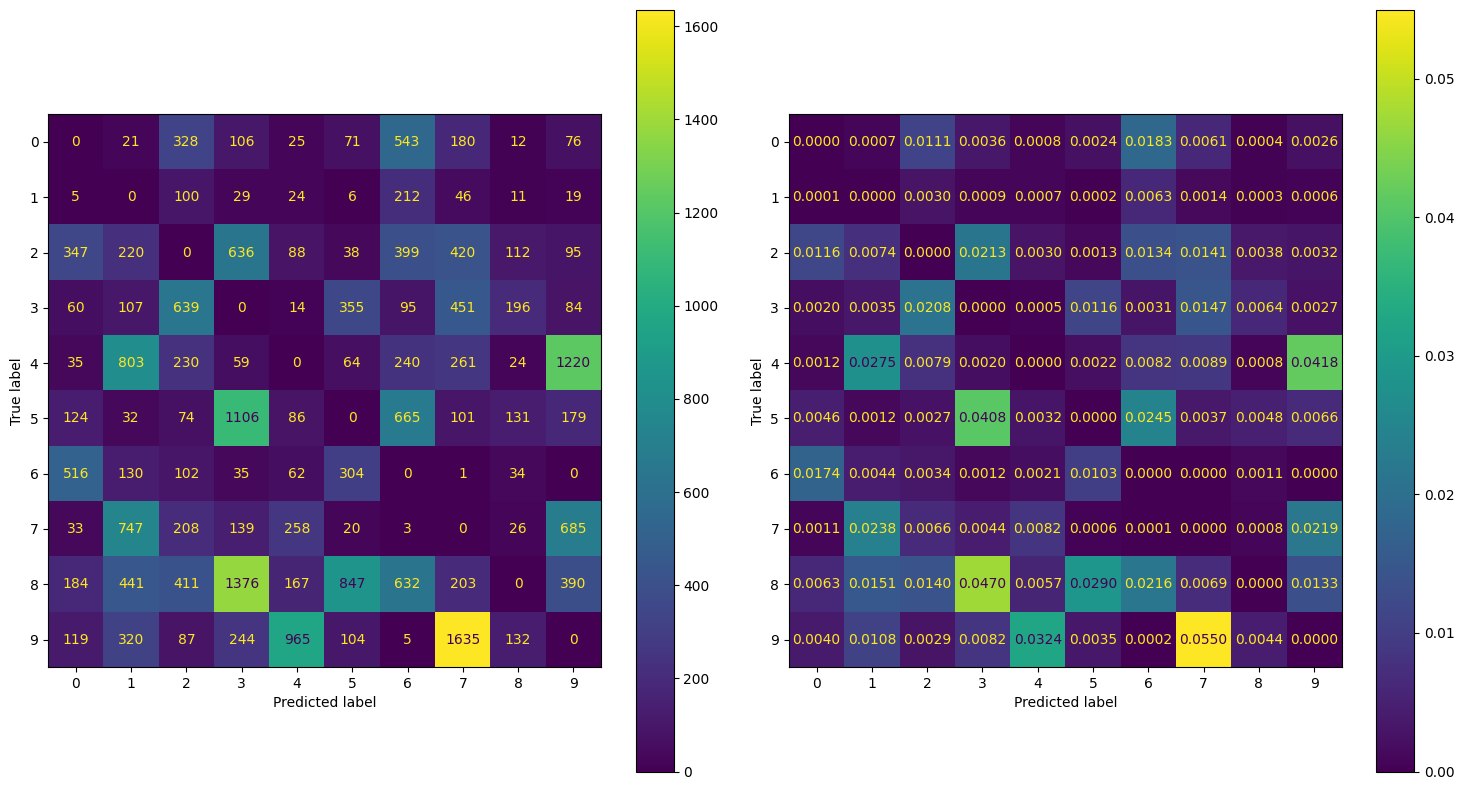

In [23]:

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

cm = confusion_matrix(train_labels, train_predicted_labels)
cm_normalized = confusion_matrix(train_labels, train_predicted_labels, normalize="true")

np.fill_diagonal(cm, 0)
np.fill_diagonal(cm_normalized, 0)

ConfusionMatrixDisplay(cm, display_labels=classifier.classes_).plot(ax=axes[0])
ConfusionMatrixDisplay(cm_normalized, display_labels=classifier.classes_).plot(ax=axes[1], values_format=".4f")

plt.tight_layout()
plt.show()

## Grid Search